In [1]:
using DynamicalSystems
using DifferentialEquations
using OrdinaryDiffEq
using StaticArrays
using Statistics
using CairoMakie


In [2]:
function sigma(x)
    return 1.0 / ( 1.0 + exp( -10.0 * ( x  - ( - 0.25 ) ) ) )
end

function HR(u, p, t)
        
    a, b, c, d, s, xr, r,  I, vs, k1, k2, el_link  = p
    x1, y1, z1, x2, y2, z2 = u
    
    du1 = y1 + b * x1 ^ 2 - a * x1 ^3 - z1 + I - k1 * ( x1 - vs ) * sigma(x2) + el_link * ( x2 - x1 )
    du2 = c - d * x1 ^2 - y1
    du3 = r * ( s * ( x1 - xr ) - z1 )
    
    du4 = y2 + b * x2 ^ 2 - a * x2 ^3 - z2 + I - k2 * ( x2 - vs ) * sigma(x1) + el_link * ( x1 - x2 )
    du5 = c - d * x2 ^2 - y2
    du6 = r * ( s * ( x2 - xr ) - z2 )
    return SVector(du1, du2, du3,
                    du4, du5, du6)
end
Hs(x, k) = Statistics.mean(x) + k * Statistics.std(x)

Hs (generic function with 1 method)

In [3]:
function peaks(x)
    peaks_ = Float64[]
    len_ = length(x)
    for i in range(2, len_ - 1, step = 1)
        if x[i-1] < x[i] > x[i+1]
            push!(peaks_, x[i])
        end
    end
    return peaks_
end

peaks (generic function with 1 method)

In [16]:
tspan = (0., 500000.)

a = 1.
b = 3.
c = 1.
d = 5.
xr = -1.6
r = 0.01
s = 5.
I = 4.
xv = 2.

k1= 0.2
k2 = -0.4
k = 0.0

0.0

In [17]:
p = SA[a, b, c, d, s, xr, r, I, xv, k1, k2, k]
condition = SA[0.1, 0.0, 0.0, 0.3, 0.1, 0.0]
p

12-element SVector{12, Float64} with indices SOneTo(12):
  1.0
  3.0
  1.0
  5.0
  5.0
 -1.6
  0.01
  4.0
  2.0
  0.2
 -0.4
  0.0

In [18]:
prob = ODEProblem(HR, condition, tspan, p)

ODEProblem with uType SVector{6, Float64} and tType Float64. In-place: false
timespan: (0.0, 500000.0)
u0: 6-element SVector{6, Float64} with indices SOneTo(6):
 0.1
 0.0
 0.0
 0.3
 0.1
 0.0

In [19]:
sol = solve(prob, AutoVern9(Rodas5()), abstol = 1e-11, reltol = 1e-11, maxiters = 10000000);

In [20]:
xsum = sol[1, :] + sol[4, :];
println("before: ", length(xsum))

xsum = xsum[floor(Int, length(xsum) / 4):end ]
println("after: ", length(xsum))

before: 7149243
after: 5361934


In [21]:
Hs1 = Hs(xsum, 6)
length(xsum), Hs1

(5361934, 3.294881549980675)

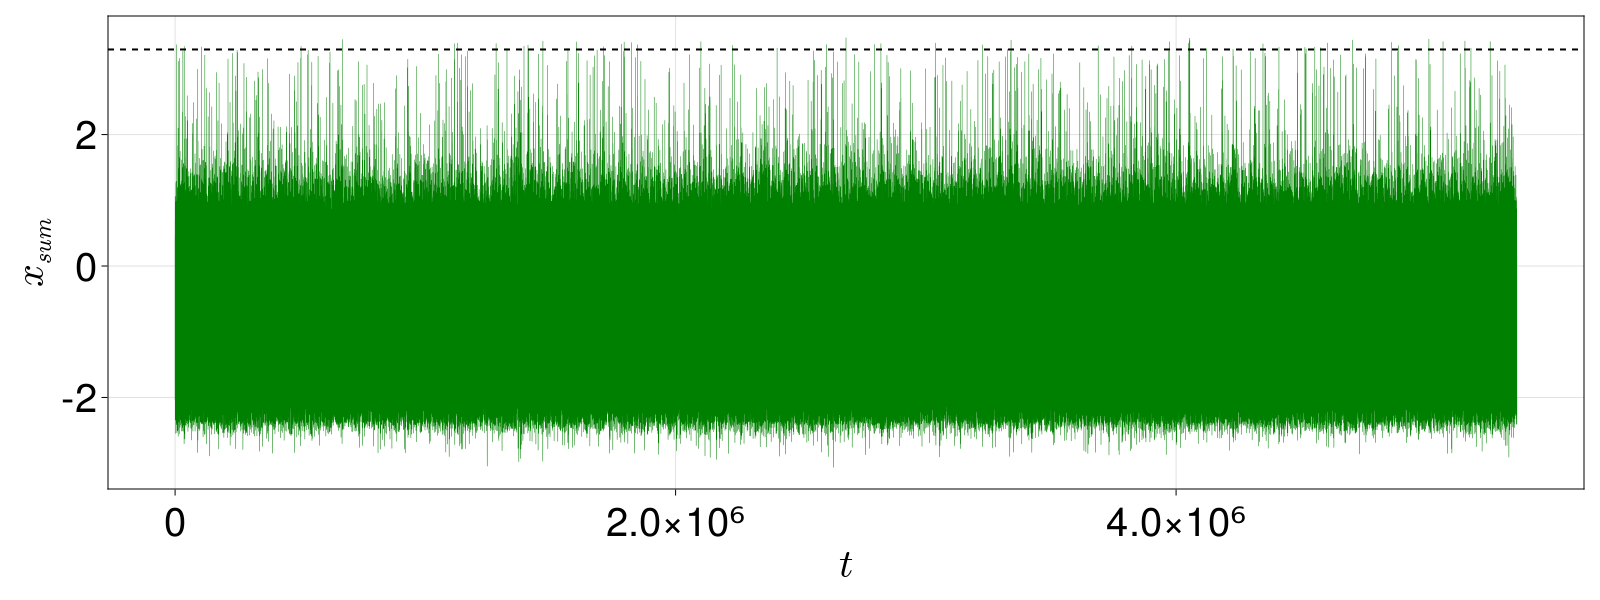

In [22]:
f = Figure(resolution = (1600, 600), fontsize = 40)
ax = Axis(f[1, 1], xlabel = L"t", ylabel = L"x_{sum}")

lines!(ax, xsum, linewidth = 0.5, color = "green")
# hlines!(Hs2, color = "red", linewidth = 1.0, linestyle = :dash)
hlines!(Hs1, color = "black", linewidth = 2.0, linestyle = :dash)

f

In [23]:
ds = ContinuousDynamicalSystem(HR, condition, p)

6-dimensional continuous dynamical system
 state:       [0.1, 0.0, 0.0, 0.3, 0.1, 0.0]
 rule f:      HR
 in-place?    false
 jacobian:    ForwardDiff
 parameters:  [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2, -0.4, 0.0]

In [24]:
lyapunovspectrum(ds, 500000; diffeq = (alg = AutoVern9(Rodas5()),
                                                            abstol = 1e-11, reltol = 1e-11,
                                                            maxiters = 10000000
                                                            ))

6-element Vector{Float64}:
   0.018842238647334086
   0.0012602247933938358
  -0.00021251208511043691
  -0.0154775744234587
  -6.683463219741865
 -11.358048449544368